In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
## get data
url = 'https://raw.githubusercontent.com/Frederick-Stein/Data-Science-Playground/refs/heads/main/Projects/Stock_Forecasting/all_stocks_5yr.csv'
data = pd.read_csv(url, delimiter=',', on_bad_lines='skip')
data.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [3]:
## EDA
print(data.shape)
print(data.info())
data['data'] = pd.to_datetime(data['date'])
data['Name'].unique().shape

(619040, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB
None


(505,)

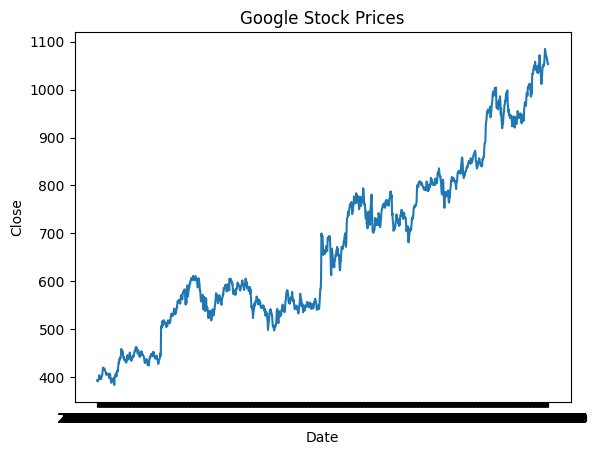

In [4]:
# prepare data
google = data[data['Name'] == 'GOOGL']
google = google[google['date'] < '2018-01-01']
plt.plot(google['date'], google['close'])
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Google Stock Prices")
plt.show()

In [5]:
prices = google[['close']].values.astype(np.float32)
T = len(prices)
train_len = int(T * 0.95)

# rerange
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit_transform(prices[:train_len])
scaled = scaler.transform(prices)  # use train stats for all
data_test = prices[train_len-60:]


# Build train windows
X_train, y_train = [], []
for i in range(60, train_len):
    X_train.append(scaled[i-60:i, 0])
    y_train.append(scaled[i, 0])

# Build test windows
X_test, y_test = [], []
for i in range(train_len, T):
    X_test.append(scaled[i-60:i, 0])  # these 60 steps include context before train_len
    y_test.append(scaled[i, 0])

X_train, y_train = np.array(X_train, dtype=np.float32), np.array(y_train, dtype=np.float32)
X_test, y_test = np.array(X_test, dtype=np.float32), np.array(y_test, dtype=np.float32)

# Reshape X_train and X_test to add the input_size dimension
X_train = torch.tensor(X_train[:, :, None])    # (N, 60, 1)
y_train = torch.tensor(y_train[:, None])       # (N, 1)
X_test  = torch.tensor(X_test[:, :, None])     # (N, 60, 1)
y_test  = torch.tensor(y_test[:, None])        # (N, 1)

print(X_train.shape)
print(y_train.shape)
dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset, batch_size = 64, shuffle = True, drop_last = True)

torch.Size([1111, 60, 1])
torch.Size([1111, 1])


In [6]:
## build model
class LSTMReg(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 1)   # output (B,1)
        )

    def forward(self, x):
        out, _ = self.lstm(x)       # (B, T, H)
        last = out[:, -1, :]        # (B, H)
        return self.head(last)      # (B, 1)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMReg(input_size=1, hidden_size=64, num_layers=2, dropout=0.2).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)


Epochs = 30
for epoch in range(1, Epochs+1):
    model.train()
    train_error = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_error += loss.item()
    train_error /= len(train_loader)
    if epoch % 5 == 0:
        print(f"Epoch {epoch+1}/{Epochs}, Train Loss: {train_error:.4f}")

Epoch 6/30, Train Loss: 0.0139
Epoch 11/30, Train Loss: 0.0048
Epoch 16/30, Train Loss: 0.0039
Epoch 21/30, Train Loss: 0.0034
Epoch 26/30, Train Loss: 0.0036
Epoch 31/30, Train Loss: 0.0034


In [16]:
model.eval()
with torch.no_grad():
    preds_test_scaled = model(X_test.to(device)).cpu().numpy()
    y_test_scaled = y_test.numpy()

# Metrics in scaled space
rmse_scaled = mean_squared_error(y_test_scaled, preds_test_scaled)
mae_scaled = mean_absolute_error(y_test_scaled, preds_test_scaled)

# Back to price space
preds_test_price = scaler.inverse_transform(preds_test_scaled)
y_test_price = scaler.inverse_transform(y_test_scaled)

rmse_price = mean_squared_error(y_test_price, preds_test_price)
mae_price = mean_absolute_error(y_test_price, preds_test_price)

print(f"Scaled  RMSE/MAE: {rmse_scaled:.4f} / {mae_scaled:.4f}")
print(f"Price   RMSE/MAE: {rmse_price:.2f} / {mae_price:.2f}")

Scaled  RMSE/MAE: 0.0035 / 0.0542
Price   RMSE/MAE: 1360.41 / 33.67


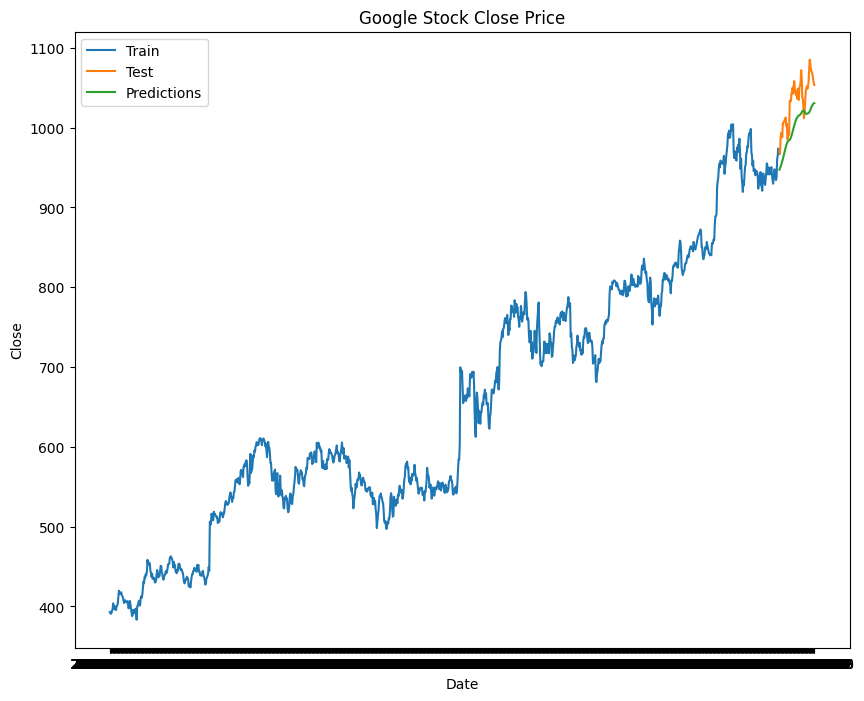

In [17]:
train = google.iloc[:train_len, :].copy()
test = google.iloc[train_len:, :].copy()
test['Predictions'] = preds_test_price

plt.figure(figsize=(10, 8))
plt.plot(train['date'], train['close'])
plt.plot(test['date'], test[['close', 'Predictions']])
plt.title('Google Stock Close Price')
plt.xlabel('Date')
plt.ylabel("Close")
plt.legend(['Train', 'Test', 'Predictions'])